![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# Libreiras adicionales
import matplotlib.pyplot as plt
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

### Solución

A continuación se calculan otras métricas adicionales para las variablea a analizar, entre las que se encuentran la desviación estándar, valores máximos y mínimos, así como los cuartiles:

In [6]:
bikes.groupby('workingday').total.describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


In [7]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


* Variable `hour`

Esta variable hace referencia a la hora del día en que se realizó un alquiler de bicicleta.<br>
Es posible ver de la ejecución de las celdas anteriores que la mayor concentración del total de alquileres se encuentra en la franja de las 16:00 a las 19:00, donde se alcanzan hasta 977 solicitudes de alquiler en punto de la demanda. Por su parte, el intervalo comprendido entre las 3:00 y las 5:00 se constituye como el periodo de tiempo en el que hay una menor cantidad de alquileres de bicicletas. 

* Variable `workingday`

Del diccionario de datos se pudo establecer que este 'feature' hace referencia a un indicativo binario que toma valor de 0 cuando la fecha de la observación registrada corresponde a un festivo o fin de semana, y asumirá valor de 1 de lo contrario. Resultado de las métricas anteriores es posible concluir que hay mayor cantidad de observaciones (7412 de 10886) que fueron registradas en días habituales que aquellas en festivos o fines de semana; sin embargo el promedio de alquileres en los días feriados es ligeramente inferior al del resto de la semana. Esto podría indicar que las personas alquilarán menos bicicletas en los fines de semana y feriados.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

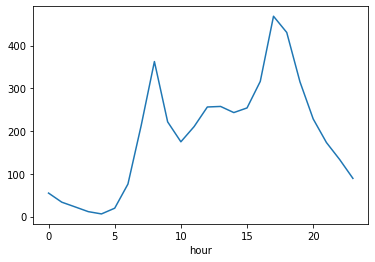

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

### Solución

A continuación se muestran las gráficas solicitadas en el enunciado y su análisis.

<AxesSubplot:xlabel='hour'>

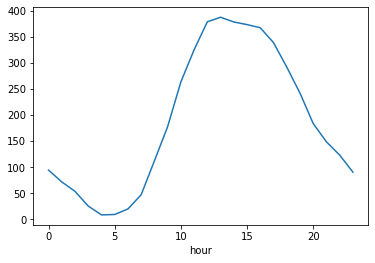

In [9]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes['workingday']==0].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

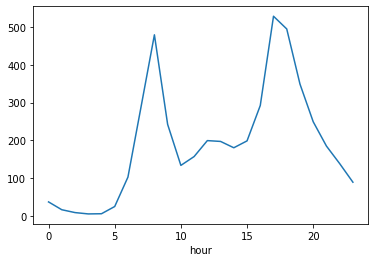

In [10]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes['workingday']==1].groupby('hour').total.mean().plot()

De las gráficas anteriores se encuentran los siguientes hallazgos:

* `hour`

En concordancia con lo descrito en el punto anterior, se muestra la presencia de dos picos de demanda en los horarios comprendidos entre las 8:00 - 9:00 y las 16:00 - 19:00 para el alquiler de bicicletas. Del mismo modo la gráfica hace más evidente la disminución en los alquileres para la franja de 3:00 - 5:00. En los horarios que se pueden considerar como inicio y fin de jornadas se ven estos incrementos en los alquileres, mientras que en las franjas de medio dia y nocturnas hay una evidente disminución.

* `workingday == 0`

Cuando la observación corresponde a un día feriado o fin de semana, se muestra un comportamiento diferente al evidenciado en la primera gráfica. En términos generales se puede ver que las diminuciones en las franjas de medio día que se veían antes han cmabiado por el contrario a ser el pico de la solicitud de alquileres de bicicletas. Se mantiene la tendencia a disminuir en cantidad de alquileres en el periodo de 3:00 a 6:00.

* `workingday == 1`

Cuando es un día 'laboral' u 'habitual', el comportamiento que se muestra en la gráfica es muy similar al comportamiento sin discriminar. Esto puede ser debido a que hay una dominancia en esta categoría respecto a la cantidad de observaciones que son de días feriados.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3
X = bikes.loc[:,['hour','workingday']]
y = bikes.total

lr =  LinearRegression().fit(X, y)
y_pred_lr = lr.predict(X)
print('Los coeficientes de las variables predictoras del modelo son: ', lr.coef_)
print('El intercepto del modelo es: ', lr.intercept_)

print('El valor del R_cuadrado del modelo es: ',r2_score(y, y_pred_lr))
print('El RMSE del modelo lineal es: ', np.sqrt(mean_squared_error(y, y_pred_lr)))

Los coeficientes de las variables predictoras del modelo son:  [10.49206282  4.07248627]
El intercepto del modelo es:  67.70595026191576
El valor del R_cuadrado del modelo es:  0.16059115011434866
El RMSE del modelo lineal es:  165.95558216733295


### Solución

1. **Procedimiento**

En el código anterior se procede a establecer como variables predictoras, conjunto de variables $X$ las indicadas en enunciado: `hour` y `workingday` y target $y$ será `total`. Una vez declaradas las variables, se procede a entrenar una regresión lineal por mínimos cuadrados usando la librería. Se genera un conjunto de predicciones 

2. **Análisis**

La ecuación de regresión del modelo lineal implementado anteriormente es:

$$\hat{Total} = \hat\beta_0 + \hat\beta_1 X_1 + \hat\beta_2 X_1$$

$$\hat{Total} = \hat\beta_0 + \hat\beta_1 hour  + \hat\beta_2 workingday $$

$$\hat{Total} = 67.706 + 10.492*hour  + 4.072*workingday $$

Se pueden interpretar los coeficientes de la siguiente forma:

* `hour`: por cada incremento de una unidad en esta variable se incrementa en 10.492 el total de alquileres de bicicletas.
* `workingday`: por cada incremento de una unidad en esta variable se incrementa en 4.072 el total de alquileres de bicicletas.

*Limitaciones*

El modelo lineal planteado es altamente interpretable como se demuestra con las ecuaciones y estimadores descritos arriba, sin embargo, dado que el $R^2$ es de 0.16, es posible indicar que la baja flexibilidad de la regresión no es capaz de explicar la varianza del fenómeno de análisis (cantidad de alquileres de ciclas), con el RMSE (Raiz del Error Cuadrático Medio) también es posible ver habrá un error esperado en cada predicción alrededor de 165.9 alquileres. En general el modelo carga demasiado sesgo para ser un buen estimador de los alquileres, sería prudente explorar otras alternativas así como incluir otros predictores de los disponibles en el conjunto de datos.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [12]:
# Celda 4

# Definición de la función que calcula el mse
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.average(np.square(y-np.average(y)))

# Definición de la función mse_gain para calular la ganancia de una variable predictora j dado el punto de corte k
def mse_gain(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    mse_gain_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    
    return mse_gain_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, mse_gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = mse_gain(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
y_pred_manual_tree = tree_predict(X, tree, proba = False)

print('El R_cuadrado del modelo basado en árboles es: ',r2_score(y, y_pred_manual_tree))
print('El MSE del modelo de árboles es: ', mean_squared_error(y, y_pred_manual_tree))
print('El RMSE del modelo de árboles es: ', np.sqrt(mean_squared_error(y, y_pred_manual_tree)))

tree

El R_cuadrado del modelo basado en árboles es:  0.6479944604591312
El MSE del modelo de árboles es:  11549.40696194607
El RMSE del modelo de árboles es:  107.46816720287953


{'y_pred': 191.57413191254824,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 9134.40591176651,
 'sl': {'y_pred': 55.437673900946024,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 3603.8503299798276,
  'sl': {'y_pred': 32.58203249442498,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 323.4004463794779,
   'sl': {'y_pred': 25.177719821162444,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 2684,
    'gain': 191.40441543023144,
    'sl': {'y_pred': 44.51045104510451,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': [1, 1.0],
     'n_samples': 909,
     'gain': 701.2852140818158,
     'sl': {'y_pred': 83.2,
      'y_prob': 82.63356164383562,
      'level': 5,
      'split': [0, 1.0],
      'n_samples': 290,
      'gain': 127.45631391200982,
      'sl': {'y_pred': 94.48965517241379,

### Solución

1. **Procedimiento**

El código anterior es una modificación del suministrado en el tutorial S1LAB1 indicando las siguientes precisiones:

* La métrica del coeficiente de Gini se reemplazó por el MSE dado que el problema de representación es de Regresión, no clasificación.
* La métrica del gini impurity se cambió por el mse_gain, el cual indica la variación del MSE entre las particiones.
* En la función tree_grow, las predicciones `y_pred` se adaptaron para calcular el promedio de las observaciones en lugar de la regla lógica según el threshold de 0.5.
* Se evaluó el desempeño entrenando y validando con la totalidad de los datos, esto dado que en el enunciado del punto anterior indican que se debe usar todo el conjunto para la validación, y posteriormente se ha de comparar este resultado contra la ejecuciñon de una librería (`scikit-learn`).
* Las métricas empleadas para evaluar son el $R^2$ , el MSE y RMSE.

2. **Análisis**

El árbol se evaluó con un criterio de parada basado en una profundidad de 6. Se encuentra un $R^2$ de 0.647 lo que implica que el modelo es capaz de representar de mejor manera la varianza inherente comparativametne con la regresión lineal simple. Se encuentra también una disminución en el valor del MSE general del modelo, lo que implica un aumento en el poder predictivo del mismo.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

Mejor Parámetro de max_depth
   max_depth     Neg - MSE
9         10 -13143.121883

El R_cuadrado del modelo basado en árboles es:  0.6547025809438785
El RMSE del modelo de árboles es:  106.43923864758072


,R_cuad,RMSE,MSE
Linear Reg,0.160591,165.955582,27541.255252
Tree,0.654703,106.439239,11329.311524


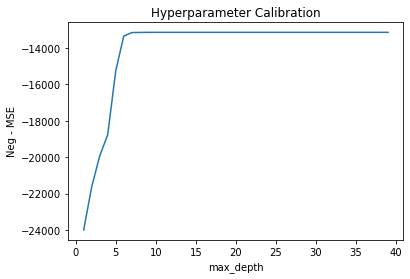

In [13]:
# Celda 5

# Se establece un rango de 1 a 40 en saltos de una unidad para explorar el desempeño predictivo
max_depth_range = range(1, 40)

# Lista para guardar los valores del MSE para cada valor de máxima profundidad (max_depth)
mse_scores = []

# Ciclo para obtener el desempeño del modelo de acuerdo con la máxima profundidad usando K-fold cross validation con 10 pliegues
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    reg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse_scores.append(cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica max_depth versus MSE (error del modelo)
plt.plot(max_depth_range, mse_scores)
plt.xlabel('max_depth')
plt.title('Hyperparameter Calibration')
plt.ylabel('Neg - MSE')

# Se obtiene el parámetro de maxima profundidad adecuado para tener el menor MSE posible
parameters = pd.DataFrame({'max_depth':max_depth_range,'Neg - MSE' : mse_scores}).sort_values(by = ['Neg - MSE','max_depth'], ascending = [False,True]).head(1)

print('Mejor Parámetro de max_depth')
print(parameters)
print()
# Entrenar el árbol de decisión haciendo uso del parámetro de calibración
reg = DecisionTreeRegressor(max_depth=parameters.iloc[0,0], random_state=1)
reg.fit(X, y)

# Generar las predicciones para todo el conjunto de datos
y_pred_tree_lib = reg.predict(X)

# Evaluación del desempeño predictivo del modelo usando Scikit-learn
print('El R_cuadrado del modelo basado en árboles es: ',r2_score(y, y_pred_tree_lib))
print('El RMSE del modelo de árboles es: ', np.sqrt(mean_squared_error(y, y_pred_tree_lib)))

model_comparison = pd.DataFrame({'R_cuad':[r2_score(y, y_pred_lr),r2_score(y, y_pred_tree_lib)],
              'RMSE':[np.sqrt(mean_squared_error(y, y_pred_lr)),np.sqrt(mean_squared_error(y, y_pred_tree_lib))],
              'MSE':[mean_squared_error(y, y_pred_lr),mean_squared_error(y, y_pred_tree_lib)]}, index = ['Linear Reg','Tree'])
model_comparison

In [14]:
pd.DataFrame({'feature':X.columns, 'importance':reg.feature_importances_}).sort_values('importance')

,feature,importance
1,workingday,0.18495
0,hour,0.81505


### Solución

1. **Procedimiento**

Se realizó una calibración manual del hiperparámetro max_depth en un espacio de 0 a 39, identificando mediante validación cruzada aquel que da el mejor MSE. Usando esta calibración se entrena el modelo de árbol de regresión y se compara contra el resultado de la regresión lineal por mínimos cuadrados construida en el punto 3. También se analiza la importancia de las variables predictoras empleadas en el modelo.

2. **Análisis**

Con una profundidad de 10 se obtiene un MSE de 13143.121, siendo el mejor de los 3 modelos creados hasta el momento (lineal, manual y optimizado por librería). Comparativamente también se evidencia que el modelo más flexible (Árbol de Regresión) tiene un $R^2$ de 0.65, que supera la capacidad de representar la varianza del fenómeno de alquiler de bicicletas.

En términos de importancia de variables,se encuentra consistencia entre los hallazgos del modelo lineal y el basado en árboles, la variable `hour` es más relevante que `workingday` para la predicción acertada de `total`.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [15]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [16]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [17]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [18]:
# Celda 6

# Regresión Logística
# Construir y entrenar el modelo de regresión logística
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)
# Predecir en la muestra de validación con la regresión logística
y_pred_log_reg = log_reg.predict(X_test)
print('El valor del F1-Score de la Reg. Logística es: ', f1_score(y_test, y_pred_log_reg))
print('El valor del Accuracy de la Reg. Logística es: ', accuracy_score(y_test, y_pred_log_reg))

# Árbol de decisión
# Construir árbol de decisión
params = {'criterion':['gini'], 'max_depth': [i for i in range(1, 40)]}
clf_tree = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid = params, cv = 10)
clf_tree.fit(X_train, y_train)
y_pred_clf_tree = clf_tree.predict(X_test)
print('El valor del F1-Score del arbol de clasificación es: ', f1_score(y_test, y_pred_clf_tree))
print('El valor del Accuracy del arbol de clasificación es: ', accuracy_score(y_test, y_pred_clf_tree))


El valor del F1-Score de la Reg. Logística es:  0.6106254203093476
El valor del Accuracy de la Reg. Logística es:  0.614
El valor del F1-Score del arbol de clasificación es:  0.6448598130841121
El valor del Accuracy del arbol de clasificación es:  0.6453333333333333


### Solucion

1. **Procedimiento**

Se crea un modelo de regresión logística, usando la librería de scikit-learn, la cual por defecto usa una regularización RIDGE, y se entrena este modelo con la muestra de entrenamiento. Después se valida con la muestra de test y se calculan las métricas solicitadas.
Se hace lo propio con el modelo de árboles de clasificación, usando una calibración de hiperparámetros mediante una búsqueda con GridSearch y validación cruzada de k-fold = 10 sobre la muestra de entrenamiento. Esto permitirá entrenar el mejor árbol empleando el max_depth inspeccionado. Se escoge esta alternativa para no tener que hacer la inspección manual como en el punto 5.
Luego se comparan las métricas de los modelos.

2. **Análisis**

La regresión logística aporta un Accuracy de 0.614 mientras que el árbol calibrado ofrece uno de 0.645, siendo el árbol mejor también en el F1-Score. Se puede concluir que el árbol de decisión tiene un mejor poder predictivo para la muestra de validación disponible.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [19]:
# Celda 7

# Escenario 1

esc_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples = 300)
esc_1.fit(X_train, y_train)
y_pred_esc_1 = esc_1.predict(X_test)
print('El valor del F1-Score del Escenario 1 es: ', f1_score(y_test, y_pred_esc_1))
print('El valor del Accuracy del Escenario 1 es: ', accuracy_score(y_test, y_pred_esc_1))
# Escenario 2

esc_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples = 300)
esc_2.fit(X_train, y_train)
y_pred_esc_2 = esc_2.predict(X_test)
print('El valor del F1-Score del Escenario 2 es: ', f1_score(y_test, y_pred_esc_2))
print('El valor del Accuracy del Escenario 2 es: ', accuracy_score(y_test, y_pred_esc_2))
# Escenario 3

esc_3 = BaggingClassifier(base_estimator=LogisticRegression(random_state = 1), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples = 300)
esc_3.fit(X_train, y_train)
y_pred_esc_3 = esc_3.predict(X_test)
print('El valor del F1-Score del Escenario 3 es: ', f1_score(y_test, y_pred_esc_3))
print('El valor del Accuracy del Escenario 3 es: ', accuracy_score(y_test, y_pred_esc_3))

El valor del F1-Score del Escenario 1 es:  0.6567567567567568
El valor del Accuracy del Escenario 1 es:  0.6613333333333333
El valor del F1-Score del Escenario 2 es:  0.631578947368421
El valor del Accuracy del Escenario 2 es:  0.6453333333333333
El valor del F1-Score del Escenario 3 es:  0.6128813559322034
El valor del Accuracy del Escenario 3 es:  0.6193333333333333


### Solución

1. **Procedimiento**

Se realiza un ensamble mediante la libreria de scikit-learn para cada uno de los escenarios y se evaluan sus desempeños.

2. **Conclusiones**

El modelo con el mejor desempeño es el ensamblado con 300 árboles de clasificación y 300 muestras bootstrap y una profundidad de 2, esto basado en que tanto su F1-Score y su Accuracy son las más altas. Por su parte el modelo sin criterio de parada por profundidad el segundo más poderoso, mientras que la regreisón logística es el modelo que tiene el poder predictivo más bajo. Sin, embargo es de anotar que ninguno de los 3 modelos tiene una dominancia clara sobre la predicción.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [20]:
# Celda 8
print('Votacion Ponderada')
#Escenario 1
clf_esc_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples = 300)

# Predicción y desempeño al hacer votación mayoritaria
clf_esc_1.fit(X_train, y_train)
y_pred_pond_esc_1 = clf_esc_1.predict(X_test)

errors_esc_1 = np.zeros(clf_esc_1.n_estimators)
y_pred_all_esc_1 = np.zeros((X_test.shape[0], clf_esc_1.n_estimators))

for i in range(clf_esc_1.n_estimators):
    oob_sample_esc_1 = ~clf_esc_1.estimators_samples_[i]
    y_pred_pond_1 = clf_esc_1.estimators_[i].predict(X_train.values[oob_sample_esc_1])
    errors_esc_1[i] = accuracy_score(y_pred_pond_1, y_train.values[oob_sample_esc_1])
    y_pred_all_esc_1[:, i] = clf_esc_1.estimators_[i].predict(X_test)
    
alpha_esc_1 = (1 - errors_esc_1) / (1 - errors_esc_1).sum()
y_pred_pond_esc_1 = (np.sum(y_pred_all_esc_1 * alpha_esc_1, axis=1) >= 0.5).astype(np.int)
print('Escenario 1')
print('El valor del F1-Score del Escenario 1 Ponderado es: ', f1_score(y_test, y_pred_pond_esc_1))
print('El valor del Accuracy del Escenario 1 Ponderado es: ', accuracy_score(y_test, y_pred_pond_esc_1))

#Escenario 2
clf_esc_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples = 300)

# Predicción y desempeño al hacer votación mayoritaria
clf_esc_2.fit(X_train, y_train)
y_pred_pond_esc_2 = clf_esc_2.predict(X_test)

errors_esc_2 = np.zeros(clf_esc_2.n_estimators)
y_pred_all_esc_2 = np.zeros((X_test.shape[0], clf_esc_2.n_estimators))

for i in range(clf_esc_2.n_estimators):
    oob_sample_esc_2 = ~clf_esc_2.estimators_samples_[i]
    y_pred_pond_2 = clf_esc_2.estimators_[i].predict(X_train.values[oob_sample_esc_2])
    errors_esc_2[i] = accuracy_score(y_pred_pond_2, y_train.values[oob_sample_esc_2])
    y_pred_all_esc_2[:, i] = clf_esc_2.estimators_[i].predict(X_test)
    
alpha_esc_2 = (1 - errors_esc_2) / (1 - errors_esc_2).sum()
y_pred_pond_esc_2 = (np.sum(y_pred_all_esc_2 * alpha_esc_2, axis=1) >= 0.5).astype(np.int)
print('Escenario 2')
print('El valor del F1-Score del Escenario 2 Ponderado es: ', f1_score(y_test, y_pred_pond_esc_2))
print('El valor del Accuracy del Escenario 2 Ponderado es: ', accuracy_score(y_test, y_pred_pond_esc_2))

#Escenario 3
clf_esc_3 = BaggingClassifier(base_estimator=LogisticRegression(random_state = 1), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples = 300)

# Predicción y desempeño al hacer votación mayoritaria
clf_esc_3.fit(X_train, y_train)
y_pred_pond_esc_3 = clf_esc_3.predict(X_test)

errors_esc_3 = np.zeros(clf_esc_3.n_estimators)
y_pred_all_esc_3 = np.zeros((X_test.shape[0], clf_esc_3.n_estimators))

for i in range(clf_esc_3.n_estimators):
    oob_sample_esc_3 = ~clf_esc_3.estimators_samples_[i]
    y_pred_pond_3 = clf_esc_3.estimators_[i].predict(X_train.values[oob_sample_esc_3])
    errors_esc_3[i] = accuracy_score(y_pred_pond_3, y_train.values[oob_sample_esc_3])
    y_pred_all_esc_3[:, i] = clf_esc_3.estimators_[i].predict(X_test)
    
alpha_esc_3 = (1 - errors_esc_3) / (1 - errors_esc_3).sum()
y_pred_pond_esc_3 = (np.sum(y_pred_all_esc_3 * alpha_esc_3, axis=1) >= 0.5).astype(np.int)
print('Escenario 3')
print('El valor del F1-Score del Escenario 3 Ponderado es: ', f1_score(y_test, y_pred_pond_esc_3))
print('El valor del Accuracy del Escenario 3 Ponderado es: ', accuracy_score(y_test, y_pred_pond_esc_3))

Votacion Ponderada
Escenario 1
El valor del F1-Score del Escenario 1 Ponderado es:  0.6631087391594397
El valor del Accuracy del Escenario 1 Ponderado es:  0.6633333333333333
Escenario 2
El valor del F1-Score del Escenario 2 Ponderado es:  0.6324549237170597
El valor del Accuracy del Escenario 2 Ponderado es:  0.6466666666666666
Escenario 3
El valor del F1-Score del Escenario 3 Ponderado es:  0.6167341430499326
El valor del Accuracy del Escenario 3 Ponderado es:  0.6213333333333333


### Solución

1. **Procedimiento**

Se realiza un ensamble ponderado mediante la libreria de scikit-learn para cada uno de los escenarios y se evaluan sus desempeños.

2. **Conclusiones**

El escenario 1 es aquel que oferta un mejor resultado predictivo de los 3 distintos modelos evaluados.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [21]:
### Celda 9

pd.DataFrame({ "F1-Score Mayoritario": [f1_score(y_test, y_pred_esc_1),f1_score(y_test, y_pred_esc_2),f1_score(y_test, y_pred_esc_3)],
               "Accuracy Mayoritario": [accuracy_score(y_test, y_pred_esc_1),accuracy_score(y_test, y_pred_esc_2),accuracy_score(y_test, y_pred_esc_3)],
               "F1-Score Ponderado": [f1_score(y_test, y_pred_pond_esc_1),f1_score(y_test, y_pred_pond_esc_2),f1_score(y_test, y_pred_pond_esc_3)],
               "Accuracy Ponderado": [accuracy_score(y_test, y_pred_pond_esc_1),accuracy_score(y_test, y_pred_pond_esc_2),accuracy_score(y_test, y_pred_pond_esc_3)]
             }, index = ['Escenario 1','Escenario 2','Escenario 3'])

,F1-Score Mayoritario,Accuracy Mayoritario,F1-Score Ponderado,Accuracy Ponderado
Escenario 1,0.656757,0.661333,0.663109,0.663333
Escenario 2,0.631579,0.645333,0.632455,0.646667
Escenario 3,0.612881,0.619333,0.616734,0.621333


### Solución

**Comentarios y Comparación de los modelos**

El método ponderado es ligeramente más acertado al momento de realizar las predicciones con el conjunto de datos en comparación a su contraprarte mayoritaria, para cualquiera de los escenarios analizados. En en general aquel que no tiene el criterio de parada sobre profundidad tiende a ser aquel que mejor desempeño tiene en las métricas revisadas.

**Ventajas /  Desventajas**

Como ventaja se puede indicar que los modelos basados en ensamble pueden ayudar disminuir la varianza de los árboles. Sin embargo la profundidad de revisión puede aumentar la complejidad del modelo y así mismo, los modelos que usan ponderaciones dependen bastante de los datos de origen para establecer los pesos de sus decisiones haciendolos dificiles de replicar con exactitud en otros entornos. El uso de modelos simples para realizar las clasificaciones como las regresiones logísticas, son bastante suceptibles a outliers, variaciones en el origen de datos y el balanceo de las clases, en contraprestación a los árboles que son relativamente más robustos a estas situaciones, por lo tanto es común encontrar que estos algoritmos más flexibles (árboles) tienen un mejor desempeño predictivo; sin embargo también suelen ser afectados por el overfitting.